<a href="https://colab.research.google.com/github/vinay-jaju/Datalit-exercises/blob/master/Kmeans_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2019-05-27 16:48:29--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  3.87MB/s    in 33s     

2019-05-27 16:49:02 (4.94 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [0]:
!mkdir cifar

In [3]:
!tar -xvf cifar-10-python.tar.gz --directory cifar

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle



def unpickle(file):
 '''Load byte data from file'''
 with open(file, 'rb') as f:
  data = pickle.load(f, encoding='latin-1')
  return data


def load_cifar10_data(data_dir):
 '''Return train_data, train_labels, test_data, test_labels
 The shape of data is 32 x 32 x3'''
 train_data = None
 train_labels = []

 for i in range(1, 6):
  data_dic = unpickle(data_dir + "/data_batch_{}".format(i))
  if i == 1:
   train_data = data_dic['data']
  else:
   train_data = np.vstack((train_data, data_dic['data']))
  train_labels += data_dic['labels']

 test_data_dic = unpickle(data_dir + "/test_batch")
 test_data = test_data_dic['data']
 test_labels = test_data_dic['labels']

 train_data = train_data.reshape((len(train_data), 3, 32, 32))
 train_data = np.rollaxis(train_data, 1, 4)
 train_labels = np.array(train_labels)

 test_data = test_data.reshape((len(test_data), 3, 32, 32))
 test_data = np.rollaxis(test_data, 1, 4)
 test_labels = np.array(test_labels)

 return train_data, train_labels, test_data, test_labels

#data_dir = 'cifar-10-batches-py'
data_dir='cifar/cifar-10-batches-py'

train_data, train_labels, test_data, test_labels = load_cifar10_data(data_dir)

print(train_data.shape)
print(train_labels.shape)

print(test_data.shape)
print(test_labels.shape)

# In order to check where the data shows an image correctly
label_encoding = unpickle(data_dir + "/batches.meta")
label_encoding=label_encoding['label_names']
print(label_encoding[0])


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)
airplane


In [0]:
train_labels[2]

9

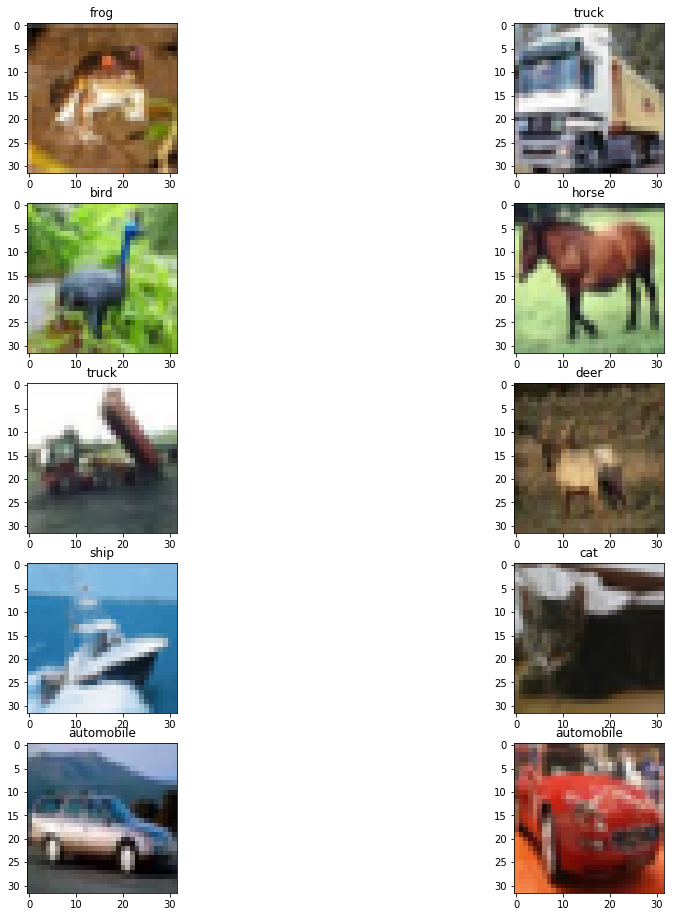

In [5]:
f, axarr = plt.subplots(5,2,figsize=(16,16))
for i in range(0,10,2):
  axarr[i%5,0].set_title(label_encoding[train_labels[i]])
  axarr[i%5,0].imshow(train_data[i],interpolation='nearest')
  axarr[i%5,1].set_title(label_encoding[train_labels[i+1]])
  axarr[i%5,1].imshow(train_data[i+1],interpolation='nearest')
  

In [0]:
reshaped_train=train_data.reshape(50000,3072)

In [7]:
reshaped_train.shape

(50000, 3072)

In [0]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.pipeline import Pipeline

In [0]:
n_categories=10
pca = PCA(n_components=10)
kmeans = KMeans(n_clusters=n_categories,max_iter=200)
predictor = Pipeline([('pca', pca), ('kmeans', kmeans)])
predict = predictor.fit(reshaped_train).predict(reshaped_train)


In [0]:
def clust_stats(cluster):
    class_freq = np.zeros(10)
    for i in range(10):
        class_freq[i] = np.count_nonzero(cluster == i)
    most_freq = np.argmax(class_freq)
    n_majority = np.max(class_freq)
    n_all = np.sum(class_freq)
    return (n_majority, n_all, most_freq)
  
def clusters_stats(predict, y):
    stats = np.zeros((10,3))
    for i in range(10):
        indices = np.where(predict == i)
        cluster = y[indices]
        stats[i,:] = clust_stats(cluster)
    return stats
  
def clusters_purity(clusters_stats):
    majority_sum  = clusters_stats[:,0].sum()
    n = clusters_stats[:,1].sum()
    return majority_sum / n

In [72]:
stats = clusters_stats(predict, train_labels)
purity = clusters_purity(stats)

print("Plotting an extract of the 10 clusters, overall purity: %f" % purity)


Plotting an extract of the 10 clusters, overall purity: 0.221680


In [0]:
def plot_d(digit, label):
    plt.axis('off')
    plt.imshow(digit.reshape((32,32,3)), cmap=plt.cm.gray)
    plt.title(label)

def plot_ds(digits, title, labels):
    n=digits.shape[0]
    n_rows=n/25+1
    n_cols=25
    plt.figure(figsize=(n_cols * 0.9, n_rows * 1.3))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    for i in range(n):
        plt.subplot(n_rows, n_cols, i + 1)
        plot_d(digits[i,:], "%d" % labels[i])
        
def plot_clusters(predict, y, stats):
    for i in range(10):
        indices = np.where(predict == i)
        title = "Most freq item %s, cluster size %d, majority %d, Label %d " % (label_encoding[int(stats[i,2])], stats[i,1], stats[i,0],stats[i,2])
        plot_ds(train_data[indices][:20], title, y[indices])

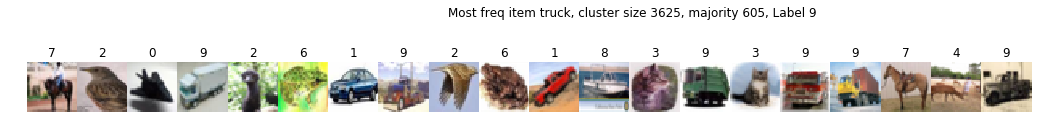

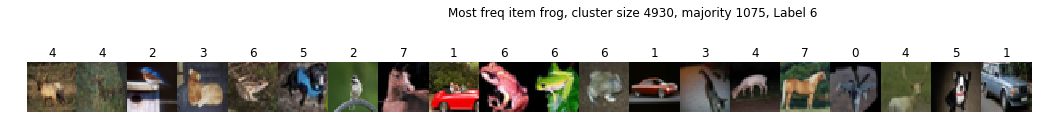

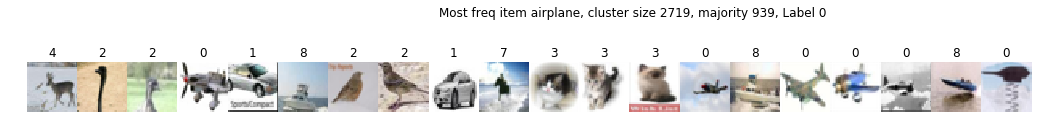

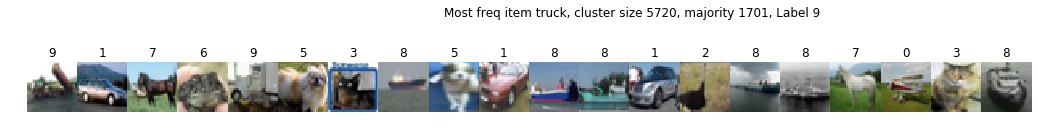

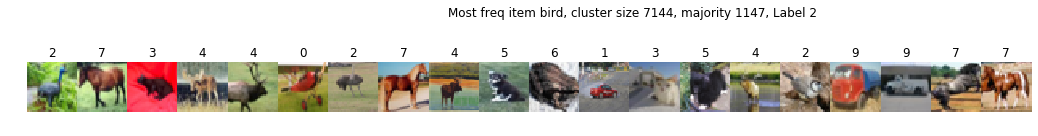

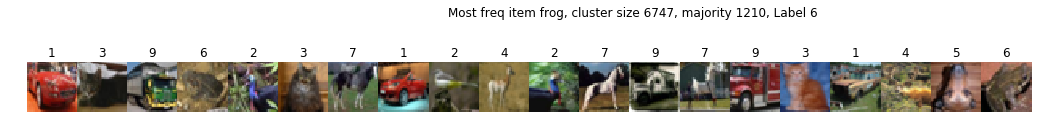

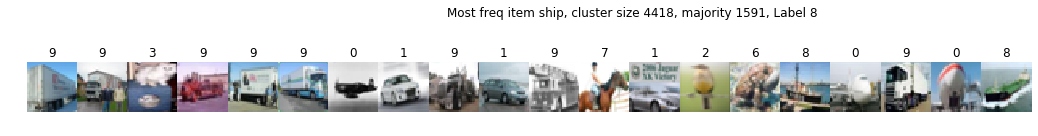

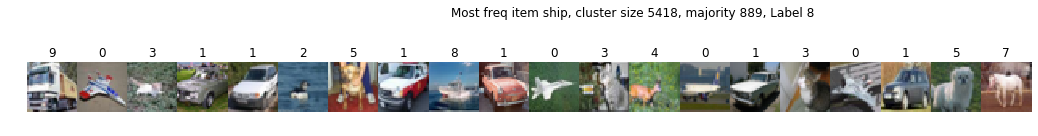

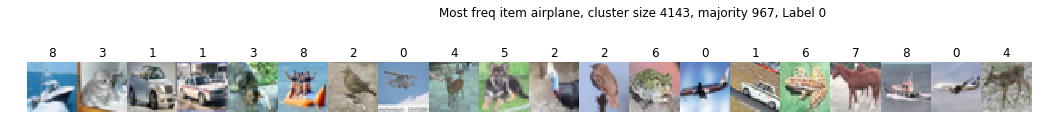

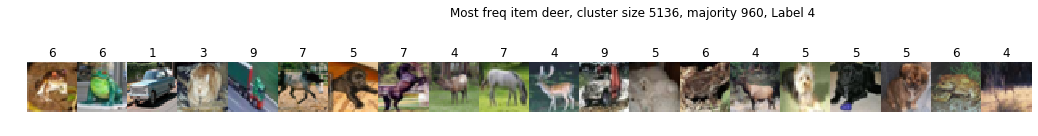

In [74]:
plot_clusters(predict, train_labels, stats)